In [ ]:
# installing

!pip install tensorflow_datasets
!pip install -U keras-tuner
!pip install tensorflow_hub
!pip install resampy
!pip install retry
!pip install pedalboard
!pip install scipy==1.7.3

In [ ]:
# collecting data from TU-Cloud download
!cp -a /recoughnition_files/. .

In [3]:
# importing libraries

# import wave
from scipy.io import wavfile
import os as os
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import IPython.display as ipd
# import sys
# import resampy
# import librosa
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
import keras_tuner as kt
# import soundfile


# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

#Preprocessing 
#import sounddevice as sd
import preprocessing as pp

# print the TF version
print(tf.__version__)

# define parameters

lengthFrame = 1
model_vggish = hub.load('https://tfhub.dev/google/vggish/1')

2.8.0


In [ ]:
# creating training data with preprocessing.py

'''
anzahl = 3000

chunk_mit= np.zeros((anzahl,256))

for i in range(anzahl):
    
    samplerate, waveform = pp.getFrame(True, lengthFrame)
    mv = model_vggish(waveform)
    mv = tf.reshape(mv, [1, 256])
    chunk_mit[i]= mv
    
Label_True=np.ones(chunk_mit.shape[0])


chunk_ohne=np.zeros((anzahl,256))

for i in range(anzahl):
    
    samplerate, waveform = pp.getFrame(False, lengthFrame)
    mv = model_vggish(waveform)
    mv = tf.reshape(mv, [1, 256])
    chunk_ohne[i]=mv
    
Label_False=np.zeros(chunk_ohne.shape[0])


print(chunk_mit.shape)

print(chunk_ohne.shape)

X_train, y_train=np.concatenate((chunk_mit,chunk_ohne)),np.concatenate((Label_True,Label_False)) 

np.save('X_train2.npy', X_train)
np.save('y_train2.npy', y_train)
'''

In [ ]:
# creating test data with preprocessing.py

'''
anzahl = 400

chunk_mit= np.zeros((anzahl,256))

for i in range(anzahl):
    
    samplerate, waveform = pp.getFrame(True, lengthFrame)
    mv = model_vggish(waveform)
    mv = tf.reshape(mv, [1, 256])
    chunk_mit[i]= mv
    
Label_True=np.ones(chunk_mit.shape[0])


chunk_ohne=np.zeros((anzahl,256))

for i in range(anzahl):
    
    samplerate, waveform = pp.getFrame(False, lengthFrame)
    mv = model_vggish(waveform)
    mv = tf.reshape(mv, [1, 256])
    chunk_ohne[i]=mv
    
Label_False=np.zeros(chunk_ohne.shape[0])


print(chunk_mit.shape)

print(chunk_ohne.shape)

X_train, y_train=np.concatenate((chunk_mit,chunk_ohne)),np.concatenate((Label_True,Label_False)) 

np.save('X_test.npy', X_train)
np.save('y_test.npy', y_train)
'''

In [7]:
# loading saved training and test data

X_train = np.load('X_train2.npy')
y_train = np.load('y_train2.npy')

X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

#explore data
print('X_train: ', X_train.shape)

print('y_train: ', y_train.shape)



FileNotFoundError: [Errno 2] No such file or directory: 'X_test.npy'

In [ ]:
#further preprocessing for conv1d

#For Conv1D add Channel

if X_train.ndim < 4:
    X_train_shaped = np.expand_dims(X_train, axis=2)


print(X_train_shaped.shape)

#Make Label data 'class num' -> 'One hot vector'
train_label = keras.utils.to_categorical(y_train, 2)
train_label=np.fliplr(train_label)

if X_test.ndim < 4:
    X_test_shaped = np.expand_dims(X_test, axis=2)


print(X_train_shaped.shape)

#Make Label data 'class num' -> 'One hot vector'
test_label = keras.utils.to_categorical(y_test, 2)
test_label=np.fliplr(test_label)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test_shaped, test_label))


(6000, 256, 1)
(6000, 256, 1)


In [ ]:
# new model used for new training data (X_train2) with reverb coughs

from tensorflow.keras import Input, layers

# Function to build the model architecture 

metrics = [tf.keras.metrics.TrueNegatives(),
          #tf.keras.metrics.TruePositives(),
          tf.keras.metrics.FalseNegatives(),
          #tf.keras.metrics.FalsePositives(),
          #tf.keras.metrics.Precision(),
          #tf.keras.metrics.Recall(),
          tf.keras.metrics.BinaryCrossentropy(),
          tf.keras.metrics.Accuracy(),
          tf.keras.metrics.BinaryAccuracy()]

# Parameters
normalization_momentum = 0.9
input_shape = (256,1)

#Conv1D Model
input_tensor = Input(shape=(input_shape))

# Built basic sequential CNN
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=input_shape))

# Set the hp_search parameters
hp_lr = 0.0019004375238737127
#hp_dropout = 0.12256076377634811
hp_dropout = 0.25

opt = tf.keras.optimizers.Nadam(learning_rate=hp_lr)

model.add(tf.keras.layers.Conv1D(32, 3, activation="elu", kernel_initializer='he_normal'))
model.add(tf.keras.layers.BatchNormalization(momentum=normalization_momentum))
model.add(tf.keras.layers.MaxPooling1D(2))
model.add(tf.keras.layers.GaussianDropout(hp_dropout))
# model.add(tf.keras.layers.GaussianNoise(0.1))

model.add(tf.keras.layers.Conv1D(64, 3, activation="elu", kernel_initializer='he_normal'))
model.add(tf.keras.layers.BatchNormalization(momentum=normalization_momentum))
model.add(tf.keras.layers.MaxPooling1D(2))
model.add(tf.keras.layers.GaussianDropout(hp_dropout))
# model.add(tf.keras.layers.GaussianNoise(0.1))

model.add(tf.keras.layers.Conv1D(128, 3, activation="elu", kernel_initializer='he_normal'))
model.add(tf.keras.layers.BatchNormalization(momentum=normalization_momentum))
model.add(tf.keras.layers.MaxPooling1D(2))
model.add(tf.keras.layers.GaussianDropout(hp_dropout))
# model.add(tf.keras.layers.GaussianNoise(0.1))

model.add(tf.keras.layers.Conv1D(256, 3, activation="elu", kernel_initializer='he_normal'))
model.add(tf.keras.layers.BatchNormalization(momentum=normalization_momentum))
model.add(tf.keras.layers.MaxPooling1D(2))
model.add(tf.keras.layers.GaussianDropout(hp_dropout))

model.add(tf.keras.layers.GlobalMaxPooling1D())
  
model.add(tf.keras.layers.Dense(256, activation="relu"))

model.add(tf.keras.layers.Dense(2, activation='sigmoid'))

# compile
model.compile(optimizer=opt,
            loss='binary_crossentropy', 
            metrics = 'accuracy')  
    
model.summary()

history = model.fit(X_train_shaped, train_label,
          batch_size=20, 
          epochs=130,
          verbose=1,
          shuffle = True,
          validation_split = 0.2)

model.save("model.h5", overwrite=True)

    

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_43 (Conv1D)          (None, 254, 32)           128       
                                                                 
 batch_normalization_43 (Bat  (None, 254, 32)          128       
 chNormalization)                                                
                                                                 
 max_pooling1d_39 (MaxPoolin  (None, 127, 32)          0         
 g1D)                                                            
                                                                 
 gaussian_dropout_39 (Gaussi  (None, 127, 32)          0         
 anDropout)                                                      
                                                                 
 conv1d_44 (Conv1D)          (None, 125, 64)           6208      
                                                     

In [ ]:
# old model with old training data without reverb on coughs -> not as good as the newer model for the new training data

'''

#model mit conv1d
from tensorflow.keras import Input, layers

# Function to build the model architecture 


# make _models directory if not exists
os.makedirs('_models', exist_ok=True)

# remove all checkpoints
! find ./_models/ -name "*.h5" -type f -delete

metrics = [tf.keras.metrics.TrueNegatives(),
          tf.keras.metrics.TruePositives(),
          tf.keras.metrics.FalseNegatives(),
          tf.keras.metrics.FalsePositives(),
          tf.keras.metrics.Precision(),
          tf.keras.metrics.Recall(),
          tf.keras.metrics.BinaryCrossentropy()
          ]

# Parameters
batch_size = 20
normalization_momentum = 0.9
input_shape = (256,1)
dropout = 0.1

#Conv1D Model
input_tensor = Input(shape=(input_shape))

# Built basic sequential CNN
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=input_shape))
#model.add(tf.keras.layers.experimental.preprocessing.RandomContrast(0.2))
    
model.add(tf.keras.layers.Conv1D(1, 1, activation="elu", kernel_initializer='he_normal'))
model.add(tf.keras.layers.MaxPooling1D(2))
model.add(tf.keras.layers.BatchNormalization(momentum=normalization_momentum))
model.add(tf.keras.layers.GaussianDropout(dropout))
# model.add(tf.keras.layers.GaussianNoise(0.1))
  
model.add(tf.keras.layers.Conv1D(64, 3, activation="elu", kernel_initializer='he_normal'))
model.add(tf.keras.layers.MaxPooling1D(2))
model.add(tf.keras.layers.BatchNormalization(momentum=normalization_momentum))
model.add(tf.keras.layers.GaussianDropout(dropout))
# model.add(tf.keras.layers.GaussianNoise(0.1))


model.add(tf.keras.layers.Conv1D(64, 2, activation="elu", kernel_initializer='he_normal'))
model.add(tf.keras.layers.MaxPooling1D(2))
model.add(tf.keras.layers.BatchNormalization(momentum=normalization_momentum))
model.add(tf.keras.layers.GaussianDropout(dropout))
# model.add(tf.keras.layers.GaussianNoise(0.1))
       
model.add(tf.keras.layers.Conv1D(32, 3, activation="elu", kernel_initializer='he_normal'))
model.add(tf.keras.layers.BatchNormalization(momentum=normalization_momentum))
#model.add(tf.keras.layers.GaussianDropout(0.1))

model.add(tf.keras.layers.GlobalMaxPooling1D())
    
model.add(tf.keras.layers.Dense(256, activation="relu"))

model.add(tf.keras.layers.Dense(2, activation='sigmoid'))

model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=.001, clipnorm=1),
              loss='binary_crossentropy',
              metrics='accuracy')

model.summary()

history = model.fit(X_train_shaped, train_label,
          batch_size=batch_size, 
          epochs=300,
          verbose=1,
          shuffle = True,
          validation_split = 0.2)

model.save("model.h5", overwrite=True)
'''

In [ ]:
# defining model for hyperparameter tuning for new model

'''

def hyperparameter_model(hp):  
    #model mit conv1d
    from tensorflow.keras import Input, layers

    # Function to build the model architecture 

    metrics = [tf.keras.metrics.TrueNegatives(),
              #tf.keras.metrics.TruePositives(),
              tf.keras.metrics.FalseNegatives(),
              #tf.keras.metrics.FalsePositives(),
              #tf.keras.metrics.Precision(),
              #tf.keras.metrics.Recall(),
              tf.keras.metrics.BinaryCrossentropy(),
              tf.keras.metrics.Accuracy()]

    # Parameters
    # batch_size = 16
    normalization_momentum = 0.9
    input_shape = (256,1)

    #Conv1D Model
    input_tensor = Input(shape=(input_shape))

    # Built basic sequential CNN
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=input_shape))
    #model.add(norm_layer)
    #model.add(tf.keras.layers.experimental.preprocessing.RandomContrast(0.2))

    # Set the hp_search parameters
    hp_lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log') 
    # hp_opt = hp.Choice('optimizer', values = ['sgd', 'momentum', 'adam'])
    hp_lr_schedule = hp.Boolean('lr_schedule', default=False)
    #hp_filter_size = hp.Choice('filter_size', values = [32, 64, 128, 256])
    hp_dropout = hp.Float('dropout', min_value=0, max_value=0.3, sampling='linear')
    opt = tf.keras.optimizers.Nadam(learning_rate=hp_lr)
    scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_binary_accuracy', 
                                                      factor=0.1, patience=3, verbose=1, 
                                                      mode='auto', min_delta=0.0001, 
                                                      cooldown=2, min_lr=0)

    
    
    # check if schedule active
    if hp_lr_schedule:
        lr = opt.lr
    else:
        lr = hp_lr
    
    model.add(tf.keras.layers.Conv1D(32, 3, activation="elu", kernel_initializer='he_normal'))
    model.add(tf.keras.layers.BatchNormalization(momentum=normalization_momentum))
    model.add(tf.keras.layers.MaxPooling1D(2))
    model.add(tf.keras.layers.GaussianDropout(hp_dropout))
  # model.add(tf.keras.layers.GaussianNoise(0.1))
    
    model.add(tf.keras.layers.Conv1D(64, 3, activation="elu", kernel_initializer='he_normal'))
    model.add(tf.keras.layers.BatchNormalization(momentum=normalization_momentum))
    model.add(tf.keras.layers.MaxPooling1D(2))
    model.add(tf.keras.layers.GaussianDropout(hp_dropout))
  # model.add(tf.keras.layers.GaussianNoise(0.1))


    model.add(tf.keras.layers.Conv1D(128, 3, activation="elu", kernel_initializer='he_normal'))
    model.add(tf.keras.layers.BatchNormalization(momentum=normalization_momentum))
    model.add(tf.keras.layers.MaxPooling1D(2))
    model.add(tf.keras.layers.GaussianDropout(hp_dropout))
    # model.add(tf.keras.layers.GaussianNoise(0.1))
        
    model.add(tf.keras.layers.Conv1D(256, 3, activation="elu", kernel_initializer='he_normal'))
    model.add(tf.keras.layers.BatchNormalization(momentum=normalization_momentum))
    model.add(tf.keras.layers.MaxPooling1D(2))
    model.add(tf.keras.layers.GaussianDropout(hp_dropout))

    model.add(tf.keras.layers.GlobalMaxPooling1D())
      
    #model.add(tf.keras.layers.Dense(256, activation="relu"))

    model.add(tf.keras.layers.Dense(2, activation='sigmoid'))

    # compile
    model.compile(optimizer=opt,
                loss='binary_crossentropy', 
                metrics = metrics)  

    return model

'''

In [ ]:
# tuning hyperparameters of new model

'''

# empty gridsearch and log folder
! rm -rf _gridsearch/*
! rm -rf _logs/*

tuner = kt.RandomSearch(
            hyperparameter_model,
            objective=kt.Objective('val_binary_crossentropy', direction='min'),
            seed=42,
            max_trials=20,
            executions_per_trial=1,
            directory = '_gridsearch',
            project_name = 'recoughnition')

tuner.search_space_summary()

tuner.search(X_train_shaped, train_label, 
             validation_split=0.2,
             shuffle=True, 
             epochs=50,
             batch_size=20)

'''

In [ ]:
# show summary of hyperparameter search

'''
tuner.results_summary()
'''

Results summary
Results in _gridsearch/recoughnition
Showing 10 best trials
Objective(name='val_binary_crossentropy', direction='min')
Trial summary
Hyperparameters:
learning_rate: 0.0019004375238737127
lr_schedule: True
dropout: 0.12256076377634811
Score: 0.19306473433971405
Trial summary
Hyperparameters:
learning_rate: 0.006678619769811224
lr_schedule: True
dropout: 0.22804844349293232
Score: 0.2251538634300232
Trial summary
Hyperparameters:
learning_rate: 0.006718710759425462
lr_schedule: True
dropout: 0.2897757564074832
Score: 0.25592881441116333
Trial summary
Hyperparameters:
learning_rate: 0.0029044390072926946
lr_schedule: True
dropout: 0.23745778078843977
Score: 0.2609700858592987
Trial summary
Hyperparameters:
learning_rate: 0.004255555813913329
lr_schedule: True
dropout: 0.08144733397798366
Score: 0.35676535964012146
Trial summary
Hyperparameters:
learning_rate: 0.0012482904754698163
lr_schedule: True
dropout: 0.14926097062758067
Score: 0.3579890727996826
Trial summary
Hyperp

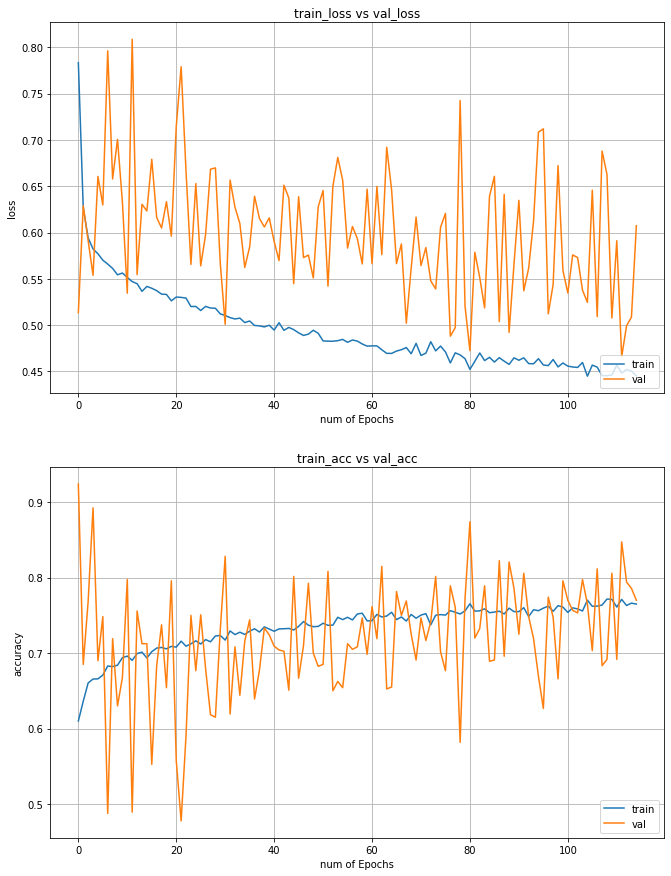

In [ ]:
# plot accuracy and loss of model

#model = keras.models.load_model("model1740.h5")

n_epochs = 130

# setup plot
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(11,15))

# plot loss
ax[0].plot(range(n_epochs), history.history['loss'])
ax[0].plot(range(n_epochs), history.history['val_loss'])
ax[0].set_ylabel('loss'), ax[0].set_title('train_loss vs val_loss')

# plot accuracy
ax[1].plot(range(n_epochs), history.history['accuracy'])
ax[1].plot(range(n_epochs), history.history['val_accuracy'])
ax[1].set_ylabel('accuracy'), ax[1].set_title('train_acc vs val_acc')

# plot adjustement
for a in ax:
    a.grid(True)
    a.legend(['train','val'], loc=4)
    a.set_xlabel('num of Epochs')
    
plt.show()


/content/recoughnition/preprocessing.py:194: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, data = scpw.read("./test_music/" + path)


(22, 256)


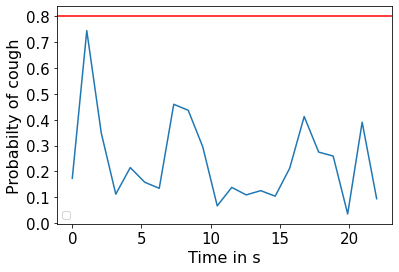

/content/recoughnition/preprocessing.py:194: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, data = scpw.read("./test_music/" + path)


001-None.wav
None
Found cough(s) at  seconds.
(22, 256)


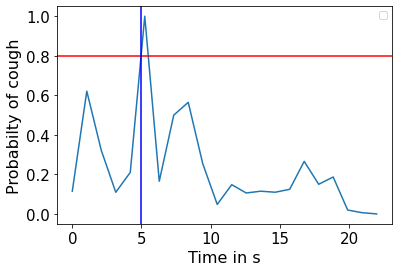

/content/recoughnition/preprocessing.py:194: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, data = scpw.read("./test_music/" + path)


001-5sec.wav
5
Found cough(s) at 5 seconds.
(22, 256)


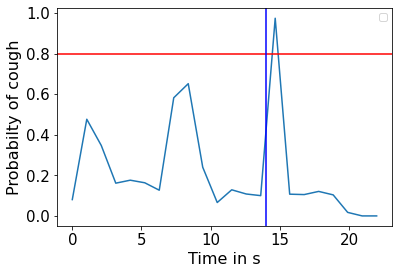

/content/recoughnition/preprocessing.py:194: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, data = scpw.read("./test_music/" + path)


001-14sec.wav
14
Found cough(s) at 15 seconds.
(35, 256)


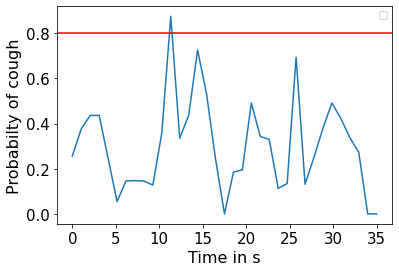

/content/recoughnition/preprocessing.py:194: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, data = scpw.read("./test_music/" + path)


002-None.wav
None
Found cough(s) at 11 seconds.
(35, 256)


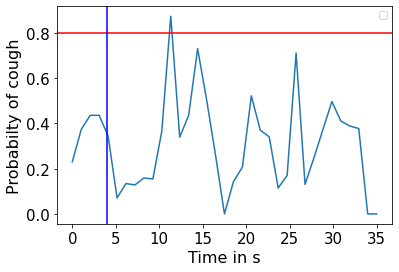

/content/recoughnition/preprocessing.py:194: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, data = scpw.read("./test_music/" + path)


002-4sec.wav
4
Found cough(s) at 11 seconds.
(35, 256)


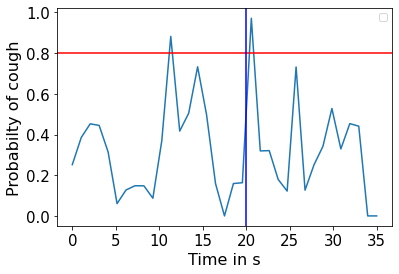

/content/recoughnition/preprocessing.py:194: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, data = scpw.read("./test_music/" + path)


002-20sec.wav
20
Found cough(s) at 11 ,21 seconds.
(45, 256)


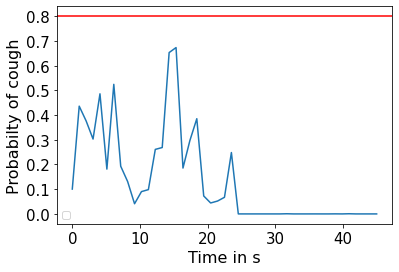

/content/recoughnition/preprocessing.py:194: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, data = scpw.read("./test_music/" + path)


003-None.wav
None
Found cough(s) at  seconds.
(45, 256)


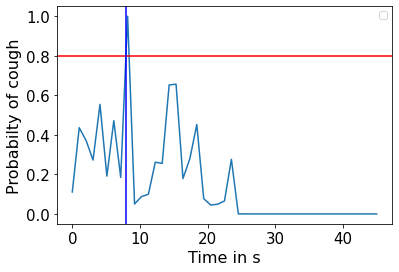

/content/recoughnition/preprocessing.py:194: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, data = scpw.read("./test_music/" + path)


003-8sec.wav
8
Found cough(s) at 8 seconds.
(45, 256)


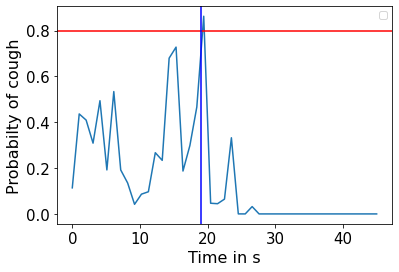

/content/recoughnition/preprocessing.py:194: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, data = scpw.read("./test_music/" + path)


003-19sec.wav
19
Found cough(s) at 19 seconds.
(45, 256)


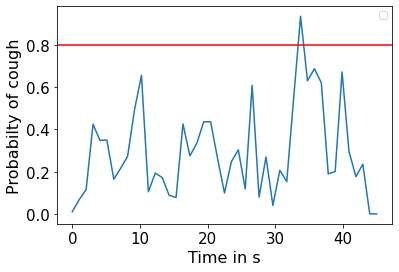

/content/recoughnition/preprocessing.py:194: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, data = scpw.read("./test_music/" + path)


004-None.wav
None
Found cough(s) at 34 seconds.
(45, 256)


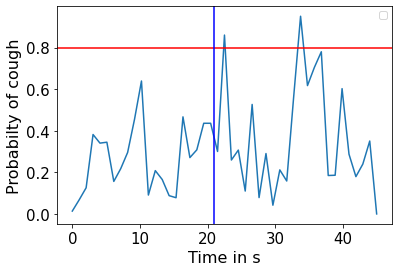

/content/recoughnition/preprocessing.py:194: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, data = scpw.read("./test_music/" + path)


004-21sec.wav
21
Found cough(s) at 22 ,34 seconds.
(45, 256)


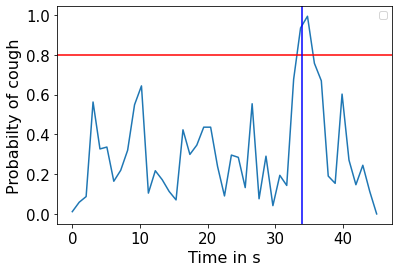

004-34sec.wav
34
Found cough(s) at 34 ,35 seconds.


In [23]:
# test model on realistic data and plot results

model = keras.models.load_model("modelfinal.h5")

test_paths = ["001-None", 
              "001-5sec", 
              "001-14sec",
              "002-None", 
              "002-4sec", 
              "002-20sec",
              "003-None",
              "003-8sec",
              "003-19sec",
              "004-None",
              "004-21sec",
              "004-34sec"]
          
threshold = 0.8

for path in test_paths:
    timeStamp = path[4:]
    if timeStamp == "None":
        timeStamp = None
    else:
        timeStamp = timeStamp[:len(timeStamp)-3]
    path = path + ".wav"
    test_music = pp.getTestFrames(path, lengthFrame)
    embeddings_file = np.zeros((len(test_music),256))

    for frame_number in range(len(test_music)):
        mv = model_vggish(test_music[frame_number])
        mv = tf.reshape(mv, [1, 256])
        embeddings_file[frame_number] = mv

    print(embeddings_file.shape)
    timecode=np.zeros(embeddings_file.shape[0])# array in sekunden

    for i in range (embeddings_file.shape[0]):

        if len(embeddings_file[i])==256:
        
            y_prob = model.predict(embeddings_file[i:i+1])
    
            timecode[i] = y_prob[0][0]

    frame_axis = np.linspace(0,len(test_music)*lengthFrame,len(timecode))
    hust_axis = timecode

    plt.plot(frame_axis,hust_axis)
    plt.axhline(y=threshold, xmin=0.0, xmax=1.0, color='r')
    if timeStamp:
      plt.axvline(x=float(timeStamp), ymin=0.0, ymax=1.0, color='b')
    plt.xlabel('Time in s', fontsize = 16)
    plt.ylabel('Probabilty of cough', fontsize = 16)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend()
    plt.show()

    timeStamps = []
    for i, frame in enumerate(hust_axis):
        if(frame >= 0.8):
            timeStamps.append(frame_axis[i])
    print(path)
    print(timeStamp)
    print("Found cough(s) at "+ ' ,'.join(str(int(f.round())) for f in timeStamps) + " seconds.")

In [ ]:
# evaluate model on test dataset

from sklearn.metrics import classification_report

model = keras.models.load_model("modelfinal.h5")

y_test_prob = model.predict(X_test_shaped)
y_test_pred = np.argmax(y_test_prob, axis=1)
y_test_true = np.argmax(np.array([y for y in test_label]), axis=1)


print('Classification report:')
print(classification_report(y_true=y_test_true, y_pred=y_test_pred))

print('------------------------------------------------:')
print('Evaluate model on test dataset:')
hist_eval = model.evaluate(X_test_shaped, test_label, batch_size = 20, return_dict = True)

Confusion matrix, without normalization


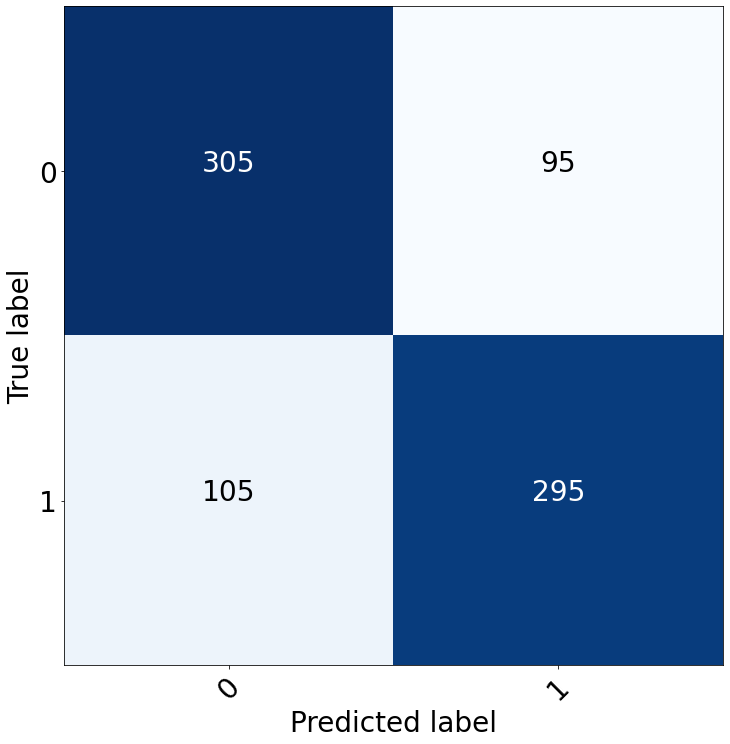

In [ ]:
 # create a confusion matrix for model evaluated on test data
 
 import itertools

 def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=28)
    plt.yticks(tick_marks, classes, fontsize=28)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center", fontsize=28,
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=28), plt.xlabel('Predicted label', fontsize=28)

    # call confusion matrix
cm = tf.math.confusion_matrix(labels=y_test_true, predictions=y_test_pred)
cm = cm.numpy()
plot_confusion_matrix(cm, classes=[0,1], normalize=False, title='Confusion matrix', cmap=plt.cm.Blues)  

/content/recoughnition/preprocessing.py:194: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, data = scpw.read("./test_music/" + path)


(4298, 256)


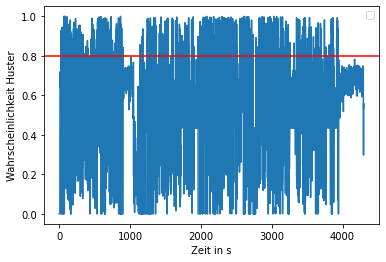

20190701MannheimDvorak9Konz1_02_M24.wav
Found cough(s) at 26 ,40 ,41 ,50 ,62 ,63 ,64 ,66 ,68 ,76 ,77 ,80 ,81 ,94 ,99 ,100 ,104 ,107 ,108 ,109 ,111 ,118 ,122 ,131 ,140 ,141 ,144 ,151 ,153 ,155 ,158 ,170 ,171 ,198 ,200 ,202 ,207 ,208 ,209 ,210 ,221 ,229 ,239 ,242 ,247 ,248 ,256 ,259 ,262 ,264 ,265 ,275 ,277 ,279 ,289 ,292 ,302 ,306 ,307 ,309 ,315 ,324 ,333 ,336 ,351 ,375 ,385 ,397 ,404 ,407 ,445 ,451 ,456 ,457 ,460 ,462 ,469 ,471 ,475 ,482 ,492 ,498 ,503 ,508 ,531 ,537 ,539 ,540 ,541 ,544 ,545 ,546 ,547 ,548 ,549 ,550 ,551 ,552 ,553 ,554 ,555 ,556 ,557 ,558 ,559 ,562 ,566 ,567 ,571 ,574 ,579 ,583 ,584 ,585 ,586 ,589 ,592 ,595 ,596 ,605 ,606 ,609 ,610 ,611 ,612 ,614 ,615 ,623 ,625 ,626 ,627 ,628 ,631 ,636 ,645 ,646 ,652 ,655 ,656 ,661 ,667 ,668 ,681 ,682 ,684 ,686 ,693 ,698 ,701 ,709 ,711 ,724 ,727 ,730 ,732 ,736 ,737 ,741 ,750 ,761 ,774 ,784 ,802 ,807 ,810 ,815 ,828 ,829 ,835 ,836 ,853 ,854 ,864 ,866 ,872 ,881 ,901 ,1136 ,1170 ,1178 ,1179 ,1243 ,1247 ,1248 ,1250 ,1253 ,1259 ,1260 ,1268 ,

In [5]:
# test model on real data and plot results

model = keras.models.load_model("modelfinal.h5")

path = '20190701MannheimDvorak9Konz1_02_M24.wav'
threshold = 0.8
test_music = pp.getTestFrames(path, lengthFrame)
embeddings_file = np.zeros((len(test_music),256))

for frame_number in range(len(test_music)):
    mv = model_vggish(test_music[frame_number])
    mv = tf.reshape(mv, [1, 256])
    embeddings_file[frame_number] = mv

print(embeddings_file.shape)
timecode=np.zeros(embeddings_file.shape[0])# array in sekunden

for i in range (embeddings_file.shape[0]):

    if len(embeddings_file[i])==256:
    
        y_prob = model.predict(embeddings_file[i:i+1])

        timecode[i] = y_prob[0][0]

frame_axis = np.linspace(0,len(test_music)*lengthFrame,len(timecode))
hust_axis = timecode


plt.plot(frame_axis,hust_axis)
plt.axhline(y=threshold, xmin=0.0, xmax=1.0, color='r')
#if timeStamp:
#  plt.axvline(x=float(timeStamp), ymin=0.0, ymax=1.0, color='b')
plt.xlabel('Zeit in s')
plt.ylabel('Wahrscheinlichkeit Huster')
plt.legend()
plt.show()

timeStamps = []
for i, frame in enumerate(hust_axis):
    if(frame >= 0.8):
        timeStamps.append(frame_axis[i])
print(path)
print("Found cough(s) at "+ ' ,'.join(str(int(f.round())) for f in timeStamps) + " seconds.")